<a href="https://colab.research.google.com/github/johnbeasley1998/NINEworkshop/blob/master/VLASS_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Galaxy Classification**
* We will start from scratch with 4 galaxy classifications. This data is not curated
* 4 categories: diffuse, disturbed, multiple, single
* Images are monocromatic 960x960 pi
* Series of 921 600 px

Steps:
1. Download data
2. Mount our Colab Drive
3. Load the data
4. Separate out training and validation data

Data is structured as:
* ./images
  * ./train
    * ./shape1
    * ./shape2
    * ./shape3
  * ./valid
    * ./shape1
    * ./shape2
    * ./shape3

In [ ]:
#Methods to read data
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.autograd import Variable




In [ ]:
train = ImageFolder('/srv/data/my_shared_data_folder/v3/train/', simple_transform)
valid = ImageFolder('/srv/data/my_shared_data_folder/v3/valid/', simple_transform)
# No noisy images yet
# noisy_train = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/noisy/train')
# noisy_valid = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/noisy/valid')

In [ ]:
#LOAD YOUR DATA HERE
print(train)
type(train)

# print(noisy_train)
# type(noisy_train)

print(valid)
type(valid)

# print(noisy_valid)
# type(noisy_valid)

Dataset ImageFolder
    Number of datapoints: 344
    Root location: /content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v1/train
Dataset ImageFolder
    Number of datapoints: 125
    Root location: /content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v1/valid


torchvision.datasets.folder.ImageFolder

In [ ]:
train.class_to_idx

{'diffuse': 0, 'disturbed': 1, 'multiple': 2, 'single': 3}

In [ ]:
# noisy_train.class_to_idx

In [ ]:
valid.class_to_idx

{'diffuse': 0, 'disturbed': 1, 'multiple': 2, 'single': 3}

In [ ]:
# noisy_valid.class_to_idx

In [ ]:
for key, value in train.class_to_idx.items():
  print('Class is: ', key, ', Index is: ', value)

Class is:  diffuse , Index is:  0
Class is:  disturbed , Index is:  1
Class is:  multiple , Index is:  2
Class is:  single , Index is:  3


**Next steps**
1. Data is already loaded into 2 variables: train and validate
2. Identify the modules you will need for the classifier


In [ ]:
import torch #Main torch library
import torch.nn as nn #Neural Network module, we will build our class
import torchvision #Used earlier for data import
import torchvision.transforms as transforms
import torch.nn.functional as F

We need to display some sample images. It's best to import with matplotlib. Also import numpy for good measure.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Build the image display function
#Let's use our previous example as a boiler plate
#Lets use the PyTorch built in display method, using the python imaging Library
#PIL or Pillow
from PIL import Image
import random

def imshow(img):
  img = img/2+0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


[93, 172, 77]
2 2 1


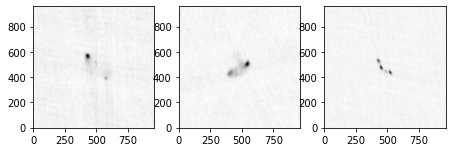

In [ ]:
#Get random images
rand_array = []

for i in range(3):
  rand_image_index = random.randint(0, len(train))
  rand_array.append(rand_image_index)

print(rand_array)

#This can be improved with another image show method
fig = plt.figure(figsize=(10,5), facecolor='white', edgecolor='black')
ax1 = fig.add_subplot(141)
ax1.imshow(train[rand_array[0]][0], origin='lower')

ax2 = fig.add_subplot(142)
ax2.imshow(train[rand_array[1]][0], origin='lower')

ax3 = fig.add_subplot(143)
ax3.imshow(train[rand_array[2]][0], origin='lower')
print(train[rand_array[0]][1], train[rand_array[1]][1], train[rand_array[2]][1])
#train.class_to_idx.items()
#{'circle': 0, 'square': 1, 'star': 2, 'triangle': 3}

**Define NN**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #in channel
    #Two convolution kernels
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(3380, 50) #Transformation variable
    # 921 600
    self.fc2 = nn.Linear(50, 4)

#Forward method is basically a recursion relationship
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(x.size(0), -1) #Resize
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training) #Inherited from nn.Module
    x = F.relu(self.fc2(x))
    
    return F.log_softmax(x, dim=1)

model = Net()

In [ ]:
type(model)

__main__.Net

In [ ]:
print(model) #Print out model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3380, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
)


In [ ]:
# Define an optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.05) #Brian used momentum=5
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.05
    nesterov: False
    weight_decay: 0
)

In [ ]:
#Transforming data to tensor so it can be used by the network
#Also normalize the data, so it's between -1 to 1. Supply the mean and std 
#We need a transform matrix to resize our images and add the transformation parameters
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
from torchvision import transforms
from torchvision import models
from torchvision import datasets

simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainset = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v1/train', simple_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v1/valid', simple_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = train.class_to_idx.keys()
print(classes)


dict_keys(['diffuse', 'disturbed', 'multiple', 'single'])


To use the NN class we need to define an optimizer.
In order to utilize the new neural network class, we need to define an optimizer with torch.optim

In [ ]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
  if phase == 'training':
    model.train()
  elif phase == 'validation':
    model.eval()
    volatile=True
  running_loss = 0.0
  running_correct = 0.0

  for batch_idx, (data, target) in enumerate(data_loader):
    data, target = Variable(data, volatile), Variable(target)
  
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)

    running_loss += F.nll_loss(output, target, size_average=False).data
    preds = output.data.max(dim=1, keepdim=True)[1] 
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()

    if phase == 'training':
      loss.backward()
      optimizer.step()
  loss = running_loss / len(data_loader.dataset)
  accuracy = 100. * running_correct / len(data_loader.dataset)

  print(f'{phase} loss is {loss} and {phase} accuracy is {running_correct} / {len(data_loader.dataset)} = {accuracy}')
  return loss, accuracy


In [ ]:
#Define loss function and accuracy
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

train_data_loader = torch.utils.data.DataLoader(trainset,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(testset,batch_size=32,num_workers=3,shuffle=True)

In [ ]:
for epoch in range(1,20):
  #train model
  #validate
  #update lists
  #Make simple graph of loss function
  epoch_loss, epoch_accuracy = fit(epoch, model, train_data_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_data_loader, phase='validation')
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 1.3031067848205566 and training accuracy is 154.0 / 344 = 44.76744079589844
validation loss is 1.2541383504867554 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.2950249910354614 and training accuracy is 153.0 / 344 = 44.47674560546875
validation loss is 1.2211436033248901 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.285151481628418 and training accuracy is 148.0 / 344 = 43.02325439453125
validation loss is 1.213438868522644 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.306555151939392 and training accuracy is 128.0 / 344 = 37.20930099487305
validation loss is 1.2252732515335083 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.2718003988265991 and training accuracy is 156.0 / 344 = 45.348838806152344
validation loss is 1.2002454996109009 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.2660902738571167 and training accuracy is 152.0 / 344 = 44.1860466003418
validation loss is 1.192845821

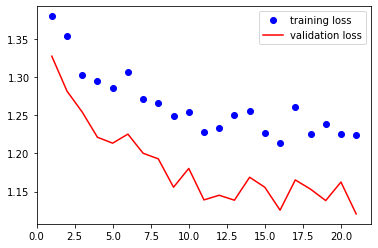

In [ ]:
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label='training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label='validation loss')
plt.legend()
plt.show()

**Images V2**

**IMAGES VERSION 2**






In [ ]:
noisy_train_losses, noisy_train_accuracy = [], []
noisy_val_losses, noisy_val_accuracy = [], []

In [ ]:
from torchvision import transforms
from torchvision import models
from torchvision import datasets

#Run this for noisy dataset
# Noisy images data loader. We can use the same transform
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

noisy_trainset = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v2/train', simple_transform)
noisy_trainloader = torch.utils.data.DataLoader(noisy_trainset, batch_size=32,num_workers=3,shuffle=True)

noisy_testset = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v2/valid', simple_transform)
noisy_testloader = torch.utils.data.DataLoader(noisy_testset, batch_size=32,num_workers=3,shuffle=True)

In [ ]:
for epoch in range(1,10):
  #train model
  #validate
  #update lists
  #Make simple graph of loss function
  epoch_loss, epoch_accuracy = fit(epoch, model, noisy_trainloader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, noisy_testloader, phase='validation')
  noisy_train_losses.append(epoch_loss)
  noisy_train_accuracy.append(epoch_accuracy)
  noisy_val_losses.append(val_epoch_loss)
  noisy_val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 1.411766767501831 and training accuracy is 24.0 / 344 = 6.976744174957275
validation loss is 1.3862178325653076 and validation accuracy is 40.0 / 125 = 32.0
training loss is 1.3873040676116943 and training accuracy is 84.0 / 344 = 24.418603897094727
validation loss is 1.385913372039795 and validation accuracy is 48.0 / 125 = 38.400001525878906
training loss is 1.3688099384307861 and training accuracy is 108.0 / 344 = 31.395349502563477
validation loss is 1.332714319229126 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.3274098634719849 and training accuracy is 137.0 / 344 = 39.82558059692383
validation loss is 1.243133783340454 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.3275679349899292 and training accuracy is 136.0 / 344 = 39.53488540649414
validation loss is 1.247147560119629 and validation accuracy is 60.0 / 125 = 48.0
training loss is 1.3123618364334106 and training accuracy is 134.0 / 344 = 38.953487396240234
validation loss i

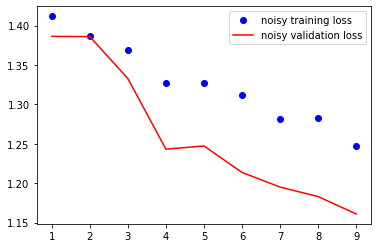

In [ ]:
#Plot loss and accuracy for noisy dataset.
plt.plot(range(1, len(noisy_train_losses)+1), noisy_train_losses, 'bo', label='noisy training loss')
plt.plot(range(1, len(noisy_val_losses)+1), noisy_val_losses, 'r', label='noisy validation loss')
plt.legend()
plt.show()

**Images V3**

**Reduced to 3 categories**

In [ ]:
v3_train_losses, v3_train_accuracy = [], []
v3_val_losses, v3_val_accuracy = [], []

In [ ]:
from torchvision import transforms
from torchvision import models
from torchvision import datasets

#Run this for noisy dataset
# Noisy images data loader. We can use the same transform
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

noisy_trainset = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v4/train', simple_transform)
noisy_trainloader = torch.utils.data.DataLoader(noisy_trainset, batch_size=32,num_workers=3,shuffle=True)

noisy_testset = ImageFolder('/content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v4/valid', simple_transform)
noisy_testloader = torch.utils.data.DataLoader(noisy_testset, batch_size=32,num_workers=3,shuffle=True)

In [ ]:
for epoch in range(1,100):
  #train model
  #validate
  #update lists
  #Make simple graph of loss function
  epoch_loss, epoch_accuracy = fit(epoch, model, noisy_trainloader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, noisy_testloader, phase='validation')
  v3_train_losses.append(epoch_loss)
  v3_train_accuracy.append(epoch_accuracy)
  v3_val_losses.append(val_epoch_loss)
  v3_val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 1.2626874446868896 and training accuracy is 1047.0 / 1395 = 75.05376434326172
validation loss is 1.1204850673675537 and validation accuracy is 373.0 / 469 = 79.53091430664062
training loss is 0.911993145942688 and training accuracy is 1121.0 / 1395 = 80.3584213256836
validation loss is 0.5868162512779236 and validation accuracy is 373.0 / 469 = 79.53091430664062
training loss is 0.5881615281105042 and training accuracy is 1137.0 / 1395 = 81.50537872314453
validation loss is 0.39843252301216125 and validation accuracy is 373.0 / 469 = 79.53091430664062
training loss is 0.46519947052001953 and training accuracy is 1129.0 / 1395 = 80.93190002441406
validation loss is 0.36353689432144165 and validation accuracy is 373.0 / 469 = 79.53091430664062
training loss is 0.43346473574638367 and training accuracy is 1133.0 / 1395 = 81.21863555908203
validation loss is 0.34810277819633484 and validation accuracy is 373.0 / 469 = 79.53091430664062
training loss is 0.40723198652267456 

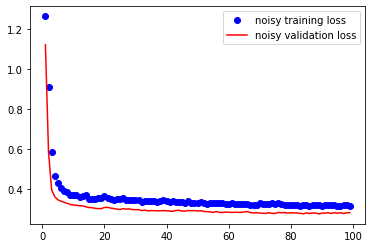

In [ ]:
#Plot loss and accuracy for v3 dataset.
plt.plot(range(1, len(v3_train_losses)+1), v3_train_losses, 'bo', label='noisy training loss')
plt.plot(range(1, len(v3_val_losses)+1), v3_val_losses, 'r', label='noisy validation loss')
plt.legend()
plt.show()